In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
import Hit_and_Run as hr
import phi_divergence as phi
from scipy.optimize import fsolve
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import weibull_min

[3.99573227 4.20603397 4.43970253 4.99466534 5.32764303 6.65955379]
[1.38629436 1.4944288  1.62186043 1.96165851 2.19722458 3.58351894]
[0.2103017  0.23366855 0.55496282 0.33297769 1.33191076]
[0.10813444 0.12743163 0.33979807 0.23556607 1.38629436]


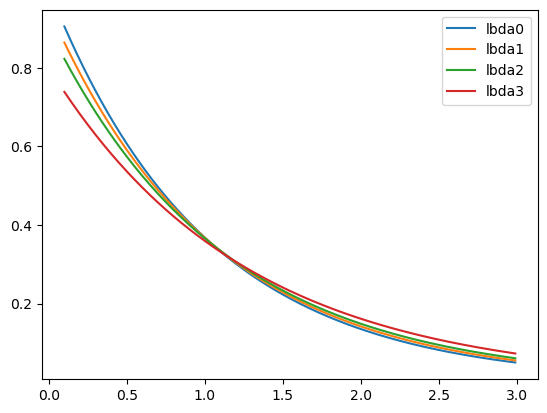

In [3]:
def f(x, a):
    return x**(a-1) * np.exp(-x)

def CVaR_wei(alfa, lbda, k):
    return(scipy.integrate.quad(f, -np.log(1-alfa), np.inf, args=1+1/k)[0]*lbda/(1-alfa))

def CVaR_exp(alfa, lbda):
    return((-np.log(1-alfa)+1)/lbda)

def entro_exp(theta, lbda):
    return(1/theta*np.log(1/(1-theta/lbda)))

def pdf_exp(x,lbda):
    return(lbda*np.exp(-lbda*x))

alfa = 0.95
lbda = [1,0.95,0.9,0.8,0.75,0.6]
k = [1, 1.2,1.5,1.9,2]
CVaR = np.zeros(len(lbda))
Entr = np.zeros(len(lbda))

for i in range(len(lbda)):
    CVaR[i] = CVaR_exp(alfa,lbda[i])
    Entr[i] = entro_exp(0.5, lbda[i])
print(CVaR)
print(Entr)
print(np.diff(CVaR))
print(np.diff(Entr))

x = np.arange(0.1,3,0.01)
y = np.zeros(len(x))
for i in range(len(lbda)-2):
    for j in range(len(x)):
        y[j] = pdf_exp(x[j],lbda[i])
    plt.plot(x,y,label = 'lbda'+str(i))
    plt.legend()

In [74]:
def bisection_method(func, a, b, tol=1e-6, max_iterations=100):

    if func(a) * func(b) >= 0:
        raise ValueError("The function must have different signs at a and b.")

    for iteration in range(max_iterations):
        mid_point = (a + b) / 2
        if abs(func(mid_point)) < tol:
            return mid_point
        if func(mid_point) * func(a) < 0:
            b = mid_point
        else:
            a = mid_point

    raise Exception("Bisection method did not converge within the maximum number of iterations.")

# Example usage:
# Define the target function (e.g., f(x) = x^2 - 4)
def target_function(x):
    return x - 4

a = -2  # Lower bound
b = 6  # Upper bound

root = bisection_method(target_function, a, b)
print("Estimated root:", root)


Estimated root: 4.0


In [20]:
def partial_pcvar(theta, p, x, alpha):
    arg0 = theta[0]-np.min([1/alpha * (x-theta[1]),0])
    arg = 1 + (arg0/theta[2])*(p-1)
    par1 = np.max([arg,0])**(1/(p-1))
    par2 = 0
    if x <= theta[1]:
        par2 = np.max([arg,0])**(1/(p-1))*(1/alpha)
    return(par1, par2)


def partial_pexp(theta, p, x):
    arg = (theta[0] + np.exp(theta[1]-x)-1)/theta[2]
    par1 = 0
    par2 = 0
    if arg > 1/(1-p):
        par1 = (1+(p-1)*arg)**(1/(p-1))
        par2 = par1 * np.exp(theta[1]-x)
    return(par1, par2)

def d_pexp_pos(theta, *data):
    p,X,r = data
    n = len(X)
    partial_1 = 0
    partial_2 = 0
    partial_3 = 0
    for i in range(n):
        par1, par2 = partial_pexp(theta, p, X[i])
        partial_1 = partial_1 + par1
        partial_2 = partial_2 + par2
        partial_3 = partial_3 + poly(p, par1)
    return(1/n*partial_1-1, 1/n*partial_2-1, 1/n*partial_3-r)


def d_pcvar_pos(theta, *data):
    p,X,alpha,r = data
    n = len(X)
    partial_1 = 0
    partial_2 = 0
    partial_3 = 0
    for i in range(n):
        par1, par2 = partial_pcvar(theta, p, X[i], alpha)
        partial_1 = partial_1 + par1
        partial_2 = partial_2 + par2
        partial_3 = partial_3 + poly(p, par1)
    return(1/n*partial_1-1, 1/n*partial_2-1, 1/n*partial_3-r)

def wc_pcvar2(root,*data):
    p,X,alpha,r = data
    n = len(X)
    wc = 0
    for i in range(n):
        arg_1 = (root[0] + 1/alpha * np.maximum(root[1]-X[i],0))/root[2]
        wc = wc + 1/n * poly_conj(p,arg_1)*root[2]
    return(wc -root[0]-root[1]+r* root[2])

def poly(p,x):
    return((x**p-p*(x-1)-1)/(p*(p-1)))

def poly_conj(p,x):
    return(1/p*np.max([1+x*(p-1),0])**(p/(p-1))-1/p)

def poly_cvar_ball(p,alpha,x,f,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [lbda-s*(1-p) <= z]
    macht = np.array([(p-1)/p, 1-(p-1)/p])
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append(z[i] <= cp.geo_mean(cp.vstack([lbda+p*t[i],lbda]),macht)) #*(-x[i])/2
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+t@f)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

def wbln_factor(x,mu,sigma):
    const = 2*(x**2)*np.sqrt(2*np.pi)*sigma
    return(const*np.exp(-x**2+((np.log(x)-mu)**2)/(2*sigma**2)))

def kl_cvar_ball(alpha,x,f,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    w = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    som = 0
    for i in range(n):
        #if wbln_factor(-x[i],0,np.sqrt(1.5)) >= 1e-5:
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append((w[i] - lbda) <= t[i])   #2/(-x[i])*
        constraints.append(cp.kl_div(lbda,w[i])+lbda+s[i]-w[i]<= 0)
        som = som + t[i]*f[i]
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

def kl_cvar_pen(alpha,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    wc = 0
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append(cp.exp(s[i]/l)-1 <= t[i])
    obj = cp.Minimize(-theta_1-theta_2+l*t @ f)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value,theta_1.value,theta_2.value)

def poly_expp(p,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(1)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [1-s/l*(1-p) <= z]
    som = 0
    for i in range(n):
        constraints.append(theta_1+cp.exp(theta_2-x[i])-1 <= s[i])
        som = som + l*f[i]*(1/p*(z[i]**(p/(p-1)))-1/p)
    constraints.append(som <= t)
    obj = cp.Maximize(theta_1+theta_2-t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value)


def poly_exp(p,x,f,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [lbda-s*(1-p) <= z]
    macht = np.array([(p-1)/p, 1-(p-1)/p])
    for i in range(n):
        constraints.append(theta_1+cp.exp(theta_2-x[i])-1 <= s[i])
        constraints.append(z[i] <= cp.geo_mean(cp.vstack([lbda+p*t[i],lbda]),macht))
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+t@f)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

def pe_cvar(p1,p2,x,f,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    theta_3 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    t2 = cp.Variable(n, nonneg = True)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [lbda-s*(1-p1) <= z]
    macht = np.array([(p1-1)/p1, 1-(p1-1)/p1])
    for i in range(n):
        constraints.append(theta_2 + cp.pos(1/alpha*(theta_3-x[i])) <= s[i])
        constraints.append(z[i] <= cp.geo_mean(cp.vstack([lbda+p1*t[i],lbda]),macht))
    obj = cp.Minimize(-theta_1-theta_2-theta_3+lbda*r+t@f)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

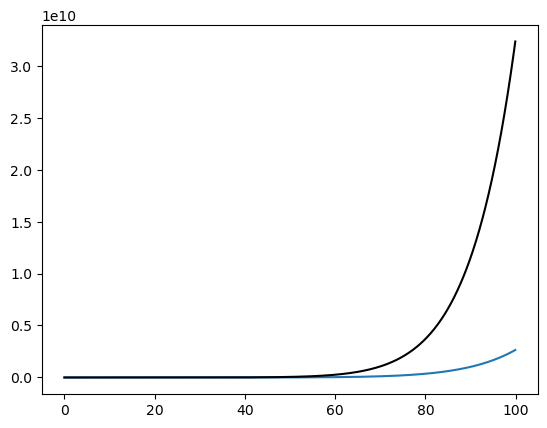

In [5]:
def log_exp(x,p):
    if x > 0 :
        return(np.exp(np.log(x+1)**p)+x-1)
    else:
        return(np.exp(x)-1)
def xlog_exp(x,p):
    if x > 0 :
        return(x*np.exp(np.log(x+2)**p)+((1-np.exp(np.log(2)**p)))*x)
    else:
        return(np.exp(x)-1)
    
def dlog_exp(x,b):
    if x > 0:
        term1 = np.exp(np.log(x+np.exp(1))**b)*(b*np.log(x+np.exp(1))**(b-1)+1)
        return(1/(2*b**2)*(term1 + (2*b**2-np.exp(1)*(b+1))))
    else:
        return(np.exp(x))
def llog_exp(x,p):
    if x > 0:
        return(np.exp((np.log(x+np.exp(1)))**p-1))
    else:
        return(np.exp(x))
def power(x,p):
    if x > 0:
        return(x**p+x)
    else:
        return(np.exp(x)-1)

def entropy(x):
    if x > 0 :
        return((x+1)*np.log(x+1))
    else:
        return(np.exp(x)-1)
x = np.arange(0,100,0.1)
y = np.zeros(len(x))
z = np.zeros(len(x))
for i in range(len(x)):
    y[i] = dlog_exp(x[i],2)
    z[i] = llog_exp(x[i]/0.7, 2.01)
plt.plot(x,y)
plt.plot(x,z, color = 'black')

In [35]:
print(dlog_exp(0.01,2))
print(llog_exp(0.01/0.1,2.01))

1.0100414824294075
1.0767433866300293


In [33]:
p = 2
alpha = 0.8
p0 = 0.01
x = np.array([3,0])
f = np.array([p0, 1-p0])
r = 0.1
sol = poly_cvar_ball(p,alpha,x,f,r)
#print(sol[0]/p0)
u_x = np.min([1/alpha * x[0],0])
#print(-poly_conj(p,-u_x))
sol2 = poly_exp(p,x,f,r)
u2_x = 1-np.exp(-x[0])
lbda = sol2[3][0]
print((sol2[0]+lbda*r)/(p0*lbda))
print(-poly_conj(p,-u2_x/lbda))
#print(sol2)
#sol3 = poly_expp(p,x,f,1)
#print(sol3)
#print(sol3[0]/p0)

16.229557907195087
0.5


In [10]:
np.random.seed(11)
n = 2000
X = -(np.random.gamma(2,0.5,size = n)) #-(np.random.pareto(2,size = n)+1)
p = 3
alpha = 0.1
r = 0.1




#print(d_pcvar_pos(root, *data))
#print(wc_pcvar2(root,*data))

In [11]:
data_exp = (p,X,r)
theta_0exp = np.array([0.96916628,-15.72457,3.23072])
root = fsolve(d_pexp_pos, theta_0exp, args = data_exp, full_output = True)
print(root[0])
print(root[1]['fvec']) 

[  0.98781023 -16.25023093   0.65854016]
[-2.39754300e-08  4.94655428e-10  4.51058868e-09]


In [83]:
data = (p,X,alpha,r)
theta_0 = np.array([-0.155,-7.367,1.924])
root = fsolve(d_pcvar_pos, theta_0, args = data, full_output = True)
print(root[0])
print(root[1]['fvec'])

(array([-0.15570417, -7.36718433,  1.92463971]),
 {'nfev': 53,
  'fjac': array([[ 3.77789174e-03,  9.99992854e-01, -1.36485338e-04],
         [ 9.88031553e-01, -3.75374995e-03, -1.54206227e-01],
         [ 1.54205637e-01, -4.47722610e-04,  9.88038674e-01]]),
  'r': array([ 1.48225434e+02,  5.56862173e+02, -8.70919170e+02, -2.10746072e+00,
          3.41130417e+00, -3.86882179e-01]),
  'qtf': array([ 1.80747166e-04,  9.30307417e-07, -9.98944517e-05]),
  'fvec': array([-1.38022713e-05,  1.80787107e-04, -9.88677101e-05])},
 1,
 'The solution converged.')

In [13]:
pcv_res=poly_cvar_ball(p,alpha,X,np.zeros(n)+1/n,r)
print(pcv_res)

(3.2349628616220754, array([-0.13134487]), array([-2.41073134]), array([2.30969277]))


In [14]:
pexp_res= poly_exp(p,X,np.zeros(n)+1/n,r)
print(pexp_res)

(1.8478721957360391, array([0.4722493]), array([-1.84787968]), array([1.57418615]))


In [66]:
x = np.arange(-0.01,-5,-0.01)
par_cv = np.array([pcv_res[1][0],pcv_res[2][0], pcv_res[3][0]])
par_exp = np.array([pexp_res[1][0],pexp_res[2][0], pexp_res[3][0]])
y1 = np.zeros(len(x))
y2 = np.zeros(len(x))
y3 = np.zeros(len(x))
for i in range(len(x)):
    y1[i] = partial_pcvar(par_cv, p, x[i], alpha)[0]*scipy.stats.gamma.pdf(-x[i], a=2, scale=0.5)
    y2[i] = partial_pexp(par_exp, p, x[i])[0]*scipy.stats.gamma.pdf(-x[i], a=2, scale=0.5)
    y3[i] = scipy.stats.gamma.pdf(-x[i], a=2, scale=0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


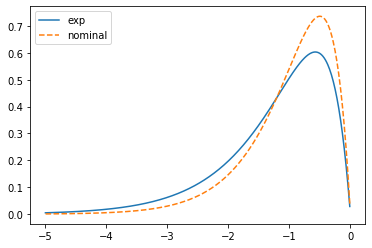

In [76]:
#plt.plot(x,y1, label = 'cvar')
plt.plot(x,y2, label = 'exp')
plt.plot(x,y3, label = 'nominal',linestyle= '--')
plt.legend()
plt.savefig('wc_exp_gamma.eps', format = 'eps')

In [10]:
np.random.seed(11)
n = 6000
X = -(np.random.pareto(2,size = n)+1)

In [172]:
-cvar_fast(0.025, X, np.zeros(n)+1/n)

12.598136505465865

In [6]:
from scipy.special import erf
from scipy.special import erfinv

def CVaR_pareto(alpha, p, xm):
    return(xm*p/((1-alpha)**(1/p)*(p-1)))

def CVaR_lognormal(alpha, mu, sigma):
    expr = (1 + erf(sigma/np.sqrt(2)-erfinv(2*alpha-1)))/(1-alpha)
    return(0.5*np.exp(mu+sigma**2/2)*expr)

def f(x, a):
    return x**(a-1) * np.exp(-x)

def CVaR_wei(alfa, lbda, k):
    return(scipy.integrate.quad(f, -np.log(1-alfa), np.inf, args=1+1/k)[0]*lbda/(1-alfa))

def CVaR_exp(alfa, lbda):
    return((-np.log(1-alfa)+1)/lbda)

    
def mle_logn(x):
    mu = np.mean(np.log(x))
    sigma = np.sum((np.log(x)-mu)**2)/len(x)
    return(mu,sigma)


print(CVaR_pareto(0.975,3.5,1))
print(CVaR_pareto(0.975,1.01,1))
print(CVaR_wei(0.975, 1, 2))


4.01660811883826
3895.106933624378
2.15473500889849


In [7]:
def d_wc_klcvar(x,theta_1,theta_2,lbda, alpha):
    teller = np.maximum(1/alpha*(theta_2-x),0) + theta_1
    return(np.exp(teller/lbda))
#weibull_min.pdf(-x, k, scale = l)
def d_wc_klcvar2(x,theta_1,theta_2,lbda, alpha):
    teller = np.maximum(1/alpha*(theta_2-x),0) + theta_1
    if theta_2-x >= 0:
        return(np.exp(teller/lbda)*(1/alpha))
    else:
        return(0)
    
def d_wc_pen_klcvar(x, theta_1, theta_2, alpha,l):
    teller = np.maximum(1/alpha*(theta_2-x),0) + theta_1
    return(np.exp(teller/l))

def d_wc_pen_klcvar2(x,theta_1,theta_2, alpha,l):
    teller = np.maximum(1/alpha*(theta_2-x),0) + theta_1
    if theta_2-x >= 0:
        return(np.exp(teller/l)*(1/alpha))
    else:
        return(0)

def wb_pdf(x,shape,scale):
    return(shape/scale * (np.abs(x)/scale)**(shape-1))

def phi_cv(x,alpha):
    if x >= 0 and x <= 1/alpha:
        return(0)


In [262]:
np.random.seed(1)
n = 5000
X = -weibull_min.rvs(c=2, loc=0, scale=1, size=n)




In [296]:
Z = np.random.lognormal(0,np.sqrt(1.2),size = 10000)
som = 0
for i in range(len(Z)):
    som = som + wbln_factor(Z[i],0,np.sqrt(1.2))
print(som/len(Z))


0.9908570862671937


In [430]:
np.random.seed(1)
m = 1
n = 5000
obj = np.zeros(m)
the1 = np.zeros(m)
the2 = np.zeros(m)
lb = np.zeros(m)
for i in range(m):
    X = -np.random.lognormal(0,np.sqrt(1.5),size = n) #-weibull_min.rvs(c=2, loc=0, scale=1, size=n)
    [obj[i], the1[i], the2[i], lb[i]] = kl_cvar_ball(1-0.975,X,np.zeros(n)+1/n,0.1)
    print(i)
print(obj)

0
[3.27605331]


In [362]:
np.exp(40*np.max(X)-np.max(-X)**2+np.log(np.max(-X))/(2*1.2))

0.0

In [39]:
for i in range(10):
    X = -weibull_min.rvs(c=2, loc=0, scale=1, size=n)
    res = kl_cvar_ball(1-0.975,X,np.zeros(n)+1/n,0.03)
    obj = np.concatenate([obj, [res[0]]])
    the1 = np.concatenate([the1, res[1]])
    the2 = np.concatenate([the2, res[2]])
    lb = np.concatenate([lb, res[3]])
    print(i)

0
1
2
3
4
5
6
7
8
9


In [431]:
theta_1 = np.mean(the1)
theta_2 = np.mean(the2)
lbda = np.mean(lb)

In [432]:
print(theta_1)
print(theta_2)
print(lbda)

0.3288976277050105
-2.4814091396440072
6.592093885433235


In [287]:
res_klp = kl_cvar_pen(0.025,X,np.zeros(n)+1/n,5)
theta1_p = res_klp[1][0]
theta2_p = res_klp[2][0]

In [11]:
#N = np.arange(500,6500,500)
N = [6000]
poly_r = np.zeros(len(N))
kl_r = np.zeros(len(N))
N

[6000]

In [8]:
N = [6000]

In [241]:
np.random.seed(3)

for i in range(len(N)):
    n = N[i]
    X = -(np.random.pareto(1,size = n )+1)
    poly_r[i] = poly_cvar_ball(3,0.025,X,np.zeros(n)+1/n,0.02)[0]
    kl_r[i] = kl_cvar_ball(1-0.975,X,np.zeros(n)+1/n,0.02)[0]
    print(poly_r[i], kl_r[i])

    





23.75818506219742 142.73221485071332
28.12136379503275 107.25336391965673
26.279932333751976 544.0106617540364
26.962250507412868 250.20834289196986
24.947748422210644 487.8485813727662
24.905650278557765 219.7242214284956
27.996009406415364 457.0703116656708
29.142329019692085 2564.1037494798297
28.156119609875542 1006.0019445634572
33.982523604184415 71322.72632665686
27.491985265602665 780.0259599585482
27.605641307749284 1262.7789319964647


In [13]:
#np.random.seed(4)
np.random.seed(4)

for i in range(len(N)):
    n = N[i]
    X = -(np.random.pareto(2,size = n )+1)
    poly_r[i] = poly_cvar_ball(3,0.025,X,np.zeros(n)+1/n,0.02)[0]
    kl_r[i] = kl_cvar_ball(1-0.975,X,np.zeros(n)+1/n,0.02)[0]
    print(poly_r[i], kl_r[i])


-inf 31.69262977024843


In [24]:
np.random.seed(4)
n = 6000
X = -(np.random.pareto(2,size = n )+1)
print(poly_cvar_ball(3,0.025,X,np.zeros(n)+1/n,0.02)[0])
print(kl_cvar_ball(1-0.975,X,np.zeros(n)+1/n,0.02)[0])

19.43268752974927
31.69262977024843


In [19]:
np.random.seed(4)
n= 1000
X = -(np.random.pareto(1,size = n )+1)
poly_cvar_ball(3,0.025,X,np.zeros(n)+1/n,0.0005)[0]

15.61909228015752

In [246]:
data = {'Sample Size': N, 'Robust CVaR Polynomial': poly_r, 'Robust CVaR KL': kl_r}
df = pd.DataFrame(data)
latex_table = df.to_latex(index=False, escape=False)

In [247]:
with open('table.tex', 'w') as file:
    file.write(latex_table)

In [225]:
poly_cvar_ball(3,0.025,Y,np.zeros(6000)+1/6000,0.02)[0]

26.909448123297338

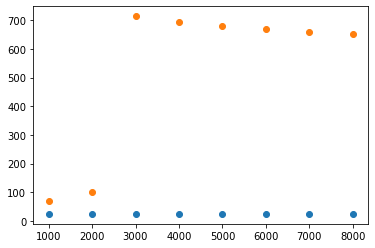

In [218]:
x = np.arange(1,9)*1000
plt.scatter(x, poly_r)
plt.scatter(x, kl_r)

In [36]:
np.random.seed(11)
n = 1000
X = -(np.random.pareto(2,size = n)+1)

In [112]:
kl_cvar_ball(1-0.975,Y,np.zeros(n)+1/n,0.03)

(729.8763809588696,
 array([-225.94488769]),
 array([-6.46319029]),
 array([21487.02423241]))

In [114]:
poly_cvar_ball(3,0.025,Y,np.zeros(n)+1/n,0.03)

(28.13837743396991,
 array([-2.76132926]),
 array([-8.71903268]),
 array([191.09188191]))

(array([4.816e+03, 1.280e+02, 3.400e+01, 1.000e+01, 4.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 1.00007959,  5.14061227,  9.28114494, 13.42167762, 17.56221029,
        21.70274297, 25.84327564, 29.98380832, 34.12434099, 38.26487367,
        42.40540634]),
 <BarContainer object of 10 artists>)

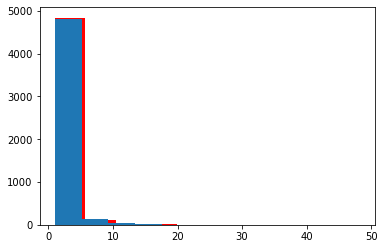

In [208]:
n= 5000
Y = -(np.random.pareto(2,size = n)+1)
Z = -(np.random.pareto(2,size = n)+1)
plt.hist(-Y, color = 'red')
plt.hist(-Z)

In [99]:
np.sum(Y>=10)

0

In [444]:
from scipy.stats import lognorm
from scipy.stats import weibull_min

Y = -np.random.lognormal(0,np.sqrt(1.5),size = 10000)
#Y= -weibull_min.rvs(c=2, loc=0, scale=1, size=10000)
som = 0
som2 = 0
som3 = 0
som4 = 0
for i in range(len(Y)):
    if (wbln_factor(-Y[i],0,np.sqrt(1.5))>= 1e-5):
        som = som + d_wc_klcvar(Y[i],theta_1, theta_2, lbda, 0.025) * wbln_factor(-Y[i],0,np.sqrt(1.5))
        som2 = som2 + d_wc_klcvar2(Y[i],theta_1, theta_2, lbda, 0.025) * wbln_factor(-Y[i],0,np.sqrt(1.5))
    #som3 = som3 + d_wc_pen_klcvar(Y[i],theta1_p, theta2_p, 0.025,5)
    #som4 = som4 + d_wc_pen_klcvar2(Y[i],theta1_p, theta2_p, 0.025,5)
print(som/len(Y))
print(som2/len(Y))
#print(som3/len(Y))
#print(som4/len(Y))
#print(theta_1)
#print(theta_2)
#print(lbda)

1.055184809690184
1.0078057122210864


In [130]:
theta_2 = theta_2+0.01

<ipython-input-44-d83514cccc07>:3: RuntimeWarning: overflow encountered in exp
  return(np.exp(teller/lbda))


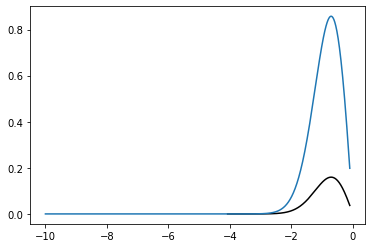

In [343]:
x1 = -np.arange(0.1, 10,0.001)
y1 = np.zeros(len(x1))
y2 = np.zeros(len(x1))
yp = np.zeros(len(x1))
for i in range(len(x1)):
    y1[i] = d_wc_klcvar(x1[i],theta_1, theta_2, lbda, 0.025)*weibull_min.pdf(-x1[i], 2, scale = 1)
    #yp[i] = d_wc_pen_klcvar(x1[i], theta1_p, theta2_p, 0.025,5)*weibull_min.pdf(-x1[i], 2, scale = 1)
    y2[i] = weibull_min.pdf(-x1[i], 2, scale = 1)
plt.plot(x1,y1, color = 'black')
plt.plot(x1,y2)
#plt.plot(x1,yp, color = 'red')

In [351]:
def kl(x,k,l,xm,p):
    if x < xm:
        return(0)
    else:
        return(np.log(p*xm**p*l/k)-(p+1)*np.log(x)+(1-k)*np.log(x/l)+(x/l)**k)
    
def f(x,k,l,xm,p):
    pdf = p*xm**p/(x**(p+1))
    return(pdf*kl(x,k,l,xm,p))

In [360]:
from scipy import integrate

# Define the function to be integrated
# Perform numerical integration using quad
def f0(x):
    return(1/x**2)

result, error = integrate.quad(f, 0,500,args= (2,1,1,10.5))  # Integrate f(x) from 0 to 1

# Print the result and estimated error
print("Result of integration:", result)
print("Estimated error:", error)

Result of integration: 1.7030460031148256
Estimated error: 9.560686209235941e-09


In [260]:
X1 = np.random.pareto(2,size = 1000)+0.1
X2 = np.random.lognormal(0,np.sqrt(1.5),size = 1000)
print(np.max(X1))
print(np.max(X2))

22.569851725117996
56.21253497953679


In [420]:
Z = np.random.pareto(10.5,size = 50000)+1
ssum = 0
for i in range(len(Z)):
    ssum = ssum + kl(Z[i],2,1,1,10.5)
print(ssum/len(Z))

1.706368950137262


In [360]:
ratio(26.7,2,1,1,2)

0.00010507422890095038 1.3284586868358083e-308


5.526762674256624e+306

In [161]:
res = mle_logn(X)
print(res)
print(CVaR_lognormal(0.975,res[0],np.sqrt(res[1])))
print(CVaR_lognormal(0.975,0,np.sqrt(1.2)))

(-0.007630202665509426, 1.219309891898142)
14.319529488558809
14.11423860767778


In [140]:
Y = np.random.lognormal(res[0], res[1],size= n)

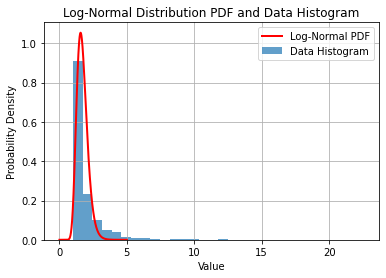

In [136]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Define the parameters for the log-normal distribution
mu = 0.5058  # Mean
sigma = 0.2346  # Standard Deviation
loc = 0  # Location Parameter (usually 0 for the standard log-normal)

# Generate example data (replace this with your own dataset)
data = -X

# Generate data points for the PDF
x = np.linspace(0, 5, 1000)  # Adjust the range as needed
pdf = lognorm.pdf(x, s=sigma, loc=loc, scale=np.exp(mu))

# Plot the histogram of data
plt.hist(data, bins=30, density=True, alpha=0.7, label='Data Histogram')

# Plot the PDF
plt.plot(x, pdf, 'r-', lw=2, label='Log-Normal PDF')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Log-Normal Distribution PDF and Data Histogram')
plt.grid(True)
plt.show()

In [186]:
p = 3
alpha = 1-0.975
radius = [0.001, 0.003, 0.005, 0.01,0.03,0.05,0.07,0.1,0.537,0.8,1]
ub = np.zeros(len(radius))
i = 0
for r in radius:
    ub[i] = poly_cvar_ball(p,alpha,X,np.zeros(n)+1/n,r)[0]
    i = i + 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11


In [187]:
ub

array([11.22477508, 12.10087767, 12.62219851, 13.42456614, 15.03460931,
       15.91045543, 16.5121027 , 17.08422624, 19.9068375 , 20.5555773 ,
       20.94003635])

In [170]:
def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] > alpha:
        return(x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(1/alpha*(Ex+last))

-cvar_fast(alpha, Y, np.zeros(n)+1/n)

NameError: name 'alpha' is not defined

In [104]:
poly_cvar_ball(p,alpha,X,np.zeros(n)+1/n,0)[0]

10.100459107199459

In [46]:
1/(2*1000)*scipy.stats.chi2.ppf(0.95, 1) 

0.001920729410347062

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1430.0587442174415
            Iterations: 23
            Function evaluations: 166
            Gradient evaluations: 22
Maximum Likelihood Estimates:
Location (loc): 0.04753977675103122
Shape (c): 0.9841297026459037
Scale (scale): 1.2305736019873825


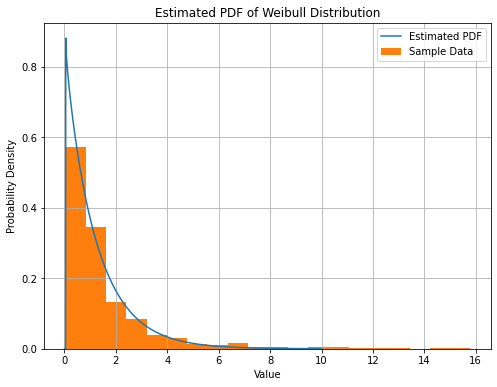

In [168]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import weibull_min

# Generate some sample data from a Weibull distribution
np.random.seed(0)
data = np.random.lognormal(0,1,size = 1000) #weibull_min.rvs(c=2, loc=3, scale=1, size=100)

# Define the likelihood function for the Weibull distribution
def negative_log_likelihood(params, data):
    loc, shape, scale = params
    if shape <= 0 or scale <= 0:
        return np.inf
    log_likelihood = np.sum(weibull_min.logpdf(data, c=shape, loc=loc, scale=scale))
    return -log_likelihood

# Initial guess for the parameters
initial_guess = [0, 1.2, 1]

def non_negativity_constraint(params):
    return params  # Ensures that x >= 0 and y >= 0
cons = ({'type': 'ineq', 'fun': non_negativity_constraint})

# Use a numerical optimizer to find the maximum likelihood estimates
result = minimize(negative_log_likelihood, initial_guess, args=(data,),constraints= cons, options={ 'disp': True})
loc_mle, shape_mle, scale_mle = result.x

# Print the estimated parameters
print("Maximum Likelihood Estimates:")
print(f"Location (loc): {loc_mle}")
print(f"Shape (c): {shape_mle}")
print(f"Scale (scale): {scale_mle}")

# Generate data points for the estimated PDF
x = np.linspace(0, 10, 1000)
pdf_estimated = weibull_min.pdf(x, c=shape_mle, loc=loc_mle, scale=scale_mle)

# Plot the estimated PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_estimated, label='Estimated PDF')
plt.hist(data, density=True, bins=20, label='Sample Data')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Estimated PDF of Weibull Distribution')
plt.grid(True)
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.1754233919517
            Iterations: 40
            Function evaluations: 202
            Gradient evaluations: 40
Maximum Likelihood Estimates:
Shape (a): 1.049899242078111
Location (loc): 1.0470872499089996
Scale (scale): 1.5639710452006437


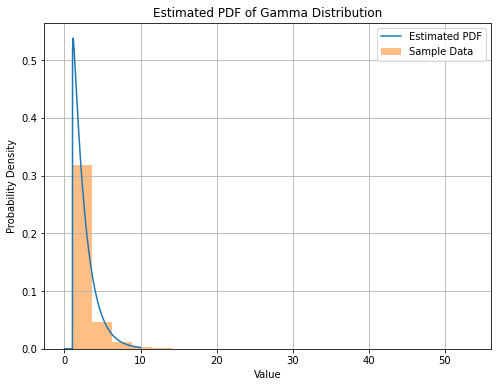

In [88]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gamma

# Generate some sample data from a gamma distribution
np.random.seed(1)
data = np.random.lognormal(0,1,size = 1000)+1

#gamma.rvs(a=2, loc=0, scale=1, size=100)

# Define the likelihood function for the gamma distribution
def negative_log_likelihood(params, data):
    shape, loc, scale = params
    if shape <= 0 or scale <= 0:
        return np.inf
    log_likelihood = np.sum(gamma.logpdf(data, a=shape, loc=loc, scale=scale))
    return -log_likelihood

# Initial guess for the parameters
initial_guess = [1, 0, 1]

def non_negativity_constraint(params):
    return params  # Ensures that x >= 0 and y >= 0
cons = ({'type': 'ineq', 'fun': non_negativity_constraint})

# Specify the non-negativity constraints using a dictionary
constraints = [{'type': 'ineq', 'fun': non_negativity_constraint}]
# Use a numerical optimizer to find the maximum likelihood estimates
result = minimize(negative_log_likelihood, initial_guess, args=(data,),constraints= cons, options={ 'disp': True})
shape_mle, loc_mle, scale_mle = result.x

# Print the estimated parameters
print("Maximum Likelihood Estimates:")
print(f"Shape (a): {shape_mle}")
print(f"Location (loc): {loc_mle}")
print(f"Scale (scale): {scale_mle}")

# Generate data points for the estimated PDF
x = np.linspace(0, 10, 1000)
pdf_estimated = gamma.pdf(x, a=shape_mle, loc=loc_mle, scale=scale_mle)

# Plot the estimated PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_estimated, label='Estimated PDF')
plt.hist(data, density=True, bins=20, alpha=0.5, label='Sample Data')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Estimated PDF of Gamma Distribution')
plt.grid(True)
plt.show()


##### Klad

for i in range(len(X)):
    gb = wc_klcvar2(X[i],theta_1,theta_2,lbda, 0.025,2,1)
    g = wc_klcvar(X[i],theta_1,theta_2,lbda, 0.025,2,1)
    som = som + -X[i]*gb+ phi_cv(gb/g, 0.025)*g
print(som/len(X))
s2 = 0
for i in range(len(X)):
    s2 = s2 + wc_klcvar2(X[i],theta_1,theta_2,lbda, 0.025,2,1)
print(s2/len(X))